In [1]:
# Initialise data matrices and import libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure

import pickle as pkl
from Bio import SeqIO
from os import listdir
from os.path import isfile, join, splitext
from collections import Counter
import string
import random

import pandas as pd
import numpy as np

import umap
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.feature_selection import chi2
from sklearn.metrics import pairwise_distances
import hdbscan


# change this to whatever directory has the script and inputData/outputData directories
inputDir="/mnt/storage5/anton/KpReplicons/inputData/"
outputDir="/mnt/storage5/anton/KpReplicons/outputData/"

In [2]:
# Load the plasmids data and convert into dataframe AssemblyFileNames x PlasmidSequenceHashes

# plasmids.tsv is made from PlasmidFinder output using /mnt/storage5/anton/generalScripts/utilities/describePlasmids.py
# it is a tab delimited file with oneline header followed by rows of
# assemblyfilename   plasmidfamilyname   referencerepliconcoverage   referencerepliconidentity   assemblyplasmidsequencehash
longData=pd.read_csv(f'{inputDir}plasmids.tsv', delimiter="\t", header=0)
PlasmidMatrixDFFull=pd.crosstab(np.array(longData.loc[:,"File"]), np.array(longData.loc[:,"hash"]))
PlasmidMatrixDFFull[PlasmidMatrixDFFull>1]=1 #ColRNAI occurs multiple times

# The kleborate output is tab delimited and contains ST, virulence and AMR data
raw_metaData=pd.read_csv(f'{inputDir}/KleborateData.tsv', sep="\t", index_col=0)
raw_metaData.index=[f+".fna" for f in raw_metaData.index] #kleborate omits fna and fasta at the end of file name

# Drop those assemblies that are not Klebsiella species complex or do not have valid GenBank ID (GCF)
raw_metaData=raw_metaData.loc[ [str(raw_metaData.at[f, "species"]).find("Klebsiella")>-1 and f[0:3]=="GCF" for f  in raw_metaData.index] ] 

# there overlap between Kleborate and plasmids.tsv is not perfect as some isolates did not have plasmids from PlasmidFinder DB
# so limit the data to the overlap between the two dataframes
PlasmidMatrixDFFull=PlasmidMatrixDFFull.loc[ np.intersect1d(PlasmidMatrixDFFull.index,raw_metaData.index) ]
metaData=raw_metaData.loc[PlasmidMatrixDFFull.index]

# As the result of above filtering for species, ID validity and presence of metadata, some PlasmidMatrixDFull columns may have have no 1's
# These need to be dropped as they have no information in them
PlasmidMatrixDFFull=PlasmidMatrixDFFull[PlasmidMatrixDFFull.columns[np.sum(PlasmidMatrixDFFull,axis=0)>0]]


In [3]:
# Add derived metadata to metaData dataframe
metaData["isCRhvKp"]="No"
metaData.loc[ (metaData["Bla_Carb_acquired"]!="-") & ( (metaData["Aerobactin"]=="-") | (metaData["Salmochelin"]=="-") ) ,"isCRhvKp"]="CRKp"
metaData.loc[ (metaData["Bla_Carb_acquired"]=="-") & ( (metaData["Aerobactin"]!="-") | (metaData["Salmochelin"]!="-") ) ,"isCRhvKp"]="hvKp"
metaData.loc[ (metaData["Bla_Carb_acquired"]!="-") & ( (metaData["Aerobactin"]!="-") | (metaData["Salmochelin"]!="-") ) ,"isCRhvKp"]="CRhvKp"


In [4]:
# Add sample collection dates and geographies based on metadata
# This section is messy due to multiple possible formatting of dates and geographies

bioSampleData={}
with open(f'{inputDir}BioSampleMetaData.tsv') as biosampleFile:
    for line in biosampleFile:
        values=line.strip().split("\t")
        if len(values)==3:
            bioSampleData[values[0]]={"Geo":values[1], "CollectionDate": values[2]}
        elif len(values)==2:
            bioSampleData[values[0]]={"Geo":values[1], "CollectionDate": ""}
        else:
            bioSampleData[values[0]]={"Geo":"", "CollectionDate": ""}
for id in metaData.index:
    shortID="GCF_"+id.replace(".fna","").replace("GCF_","").split("_")[0]
    if shortID in bioSampleData:
        if bioSampleData[shortID]["Geo"]!="":
            if bioSampleData[shortID]["Geo"].find(":")>-1:
                metaData.at[id,"BioSampleGeo"]=bioSampleData[shortID]["Geo"].split(":")[0]
                metaData.at[id,"BioSampleGeoSubregion"]=bioSampleData[shortID]["Geo"].split(":")[1]
            else:
                metaData.at[id,"BioSampleGeo"]=bioSampleData[shortID]["Geo"].split(":")[0]
                metaData.at[id,"BioSampleGeoSubregion"]=""
        if bioSampleData[shortID]["CollectionDate"].lower().find("not")>-1 or bioSampleData[shortID]["CollectionDate"].lower().find("miss")>-1 or \
                                bioSampleData[shortID]["CollectionDate"].lower().find("no")>-1 or bioSampleData[shortID]["CollectionDate"]=="":
            metaData.at[id,"CollectionDate"]="NA"
        elif len(bioSampleData[shortID]["CollectionDate"]) in [10, 7, 4, 15, 20,21]: #YYYY-MM-DD or YYYY-MM or '2013-11/2014-04', YYYY, '2020-11-15T16:39:37Z', '2017-07-05/2017-08-28'
            metaData.at[id,"CollectionDate"]=bioSampleData[shortID]["CollectionDate"][0:4]
        elif len(bioSampleData[shortID]["CollectionDate"])==9: # YYYY/YYYY
            if int(bioSampleData[shortID]["CollectionDate"][5:9])-int(bioSampleData[shortID]["CollectionDate"][0:4]) < 10 : #drop samples with very wide intervals
                metaData.at[id,"CollectionDate"]=bioSampleData[shortID]["CollectionDate"][5:9]
            else:
                metaData.at[id,"CollectionDate"]=""




In [ ]:
# Load information on Murray Collection plasmids
# Show occurences of same hashes in both Murray Collection and this dataset

murrayRepliconHashes={}
murrayRepliconNames={}
with open(f'{inputDir}/MurrayPlasmids.tsv') as murrayFile:
    murrayFile.readline()
    for line in murrayFile:
        if line.strip().split("\t")[4] not in murrayRepliconHashes:
            murrayRepliconHashes[line.strip().split("\t")[4]]=0
            murrayRepliconNames[line.strip().split("\t")[4]]=line.strip().split("\t")[1]
        murrayRepliconHashes[line.strip().split("\t")[4]]+=1

for murrayHash in murrayRepliconHashes:
    if murrayHash in PlasmidMatrixDFFull.columns:
        frequency = np.count_nonzero(PlasmidMatrixDFFull[murrayHash]>0)
        print(f'Plasmid family {murrayRepliconNames[murrayHash]} hash {murrayHash} occurs {str(murrayRepliconHashes[murrayHash])} in Murray collection and {frequency} in whole dataset')


In [6]:
# Print summary data for genotype, and CRhvKp country

print(Counter(metaData["isCRhvKp"]))
print(Counter(metaData.loc[metaData["isCRhvKp"]=="CRhvKp"]["BioSampleGeo"]))
print(Counter(raw_metaData["species"]))
print(sum(Counter(raw_metaData["species"]).values()))
print(PlasmidMatrixDFFull.shape)
print(len(np.where(np.count_nonzero(PlasmidMatrixDFFull, axis=0)>1)[0]))
print(np.mean(np.sum(PlasmidMatrixDFFull, axis=1)))
print(Counter(metaData["isCRhvKp"]))
Counter(metaData.loc[ (metaData["Aerobactin"]!="") | (metaData["Salmochelin"]!="")]["ST"])

print(len(metaData.loc[ (metaData["Aerobactin"]=="-") & (metaData["Salmochelin"]=="-")]))
print(len(metaData.loc[ (metaData["Aerobactin"]!="-") | (metaData["Salmochelin"]!="-")]))
hvIDs=metaData.index[ (metaData["Aerobactin"]!="-") | (metaData["Salmochelin"]!="-")]
print(len(np.where(np.count_nonzero(PlasmidMatrixDFFull.loc[hvIDs], axis=0)>0)[0]))

print(len(metaData.loc[ (metaData["Bla_Carb_acquired"]!="-") ]))
print(len(metaData.loc[ (metaData["Bla_Carb_acquired"]=="-") ]))
carbIDs=metaData.index[ (metaData["Bla_Carb_acquired"]!="-")]
print(len(np.where(np.count_nonzero(PlasmidMatrixDFFull.loc[carbIDs], axis=0)>1)[0]))

# IncHI1B(p-NDM-MAR) from cluster 1
repliconIDs=PlasmidMatrixDFFull.index[PlasmidMatrixDFFull["7dbc5080f77cf3407e27b13ce8d25f4f"]>0]
print(len(repliconIDs))
print(Counter(metaData.loc[repliconIDs,"BioSampleGeo"]))
print(Counter(metaData.loc[repliconIDs,"K_locus"]))


Counter({'CRKp': 5755, 'No': 4832, 'CRhvKp': 1028, 'hvKp': 853})
Counter({'China': 696, 'Russia': 64, 'Thailand': 44, 'Italy': 39, 'India': 25, 'USA': 22, 'Singapore': 22, 'Germany': 20, 'Egypt': 10, 'Missing': 9, 'Pakistan': 9, 'United Kingdom': 6, 'not applicable': 6, 'France': 5, 'Lebanon': 5, 'Turkey': 4, 'Switzerland': 4, 'missing': 3, 'Malaysia': 3, 'Brazil': 2, 'Spain': 2, 'Unknown': 2, 'Canada': 2, 'Czech Republic': 2, 'Iran': 2, 'Greece': 2, 'Romania': 2, 'Belgium': 2, 'Latvia': 2, 'Tunisia': 1, 'Guatemala': 1, 'Saudi Arabia': 1, 'Colombia': 1, 'Taiwan': 1, 'Australia': 1, 'South Korea': 1, 'Ukraine': 1, 'Hong Kong': 1, 'Bangladesh': 1, 'N/A': 1, 'Viet Nam': 1})
Counter({'Klebsiella pneumoniae': 11820, 'Klebsiella variicola subsp. variicola': 428, 'Klebsiella quasipneumoniae subsp. similipneumoniae': 416, 'Klebsiella aerogenes': 299, 'Klebsiella quasipneumoniae subsp. quasipneumoniae': 188, 'Klebsiella Ka4': 15, 'Klebsiella variicola subsp. tropica': 9, 'Klebsiella Ka3': 3})
1

In [7]:
# Load list of plasmid sequence hashes and their nucleotide sequences
# There is a likely bug in PlasmidFinder. 
# PlasmidFinder uses BLAST to identify replicon sequences in the fasta files.
# One of the BLAST outputs is the sequence in fasta file which matches the database replicon sequence
# PlasmidFinder has an option (-x) to return these matched sequences
# Examination of plasmidFinder scripts showed it uses md5 hashing algorithm 
# I have attempted to identify the correpondence between replicons sequences and replicon hashes returned by PlasmidFinder
# By using same algorithm to hash all returned replicon sequences, I wanted to match sequence to hash
# This has partially worked - only some sequences returned a hash that matched one of the hashes returned by PlasmidFinder
# Further examination of PlasmidFinder script identified that the sequence on which hash is calculated is truncated version of sequence returned by BLAST
# I have generated truncated versions of the sequences returned by PlasmidFinder by removing one nucleotide at a time from start and end of sequence
# Many of the the hashes generated from these truncated sequence matched the hashes returned by PlasmidFinder
# These matches are not accidental due to nature of hashing algorithm
# The truncation method above worked well, but it still left some hashes for which nucleotide sequence could not be identified.
# The list of valid hashes is in plasmidSequencesAndHashes.txt
# The hashes with missing nucleotide sequences can be identified from repliconFrequencies.tsv based on which hashes (Col 1) have blank sequence (last Col)

hashFamilies={}
with open(f'{inputDir}/plasmids.tsv') as plasmidsFile:
    plasmidsFile.readline()
    for line in plasmidsFile:
        hashFamilies[line.strip().split("\t")[4]]=line.strip().split("\t")[1]

hashSequences={}
with open(f'{inputDir}/plasmidSequencesAndHashes.txt') as inputfile:
    for line in inputfile:
        try:
            hashSequences[line.strip().split("\t")[0]]=line.strip().split("\t")[1]
        except BaseException:
            print(line)


In [8]:
# Run Monte Carlo type clustering
# This doesn't need to run everytime, instead saved data file can be used instead
# The subsequent analysis is based on file umapRuns_mindist_001_neighbours_30_dims_2.pkl
from sklearn.metrics import pairwise_distances

idsToEmbed=[f for f in metaData.index if metaData.at[f, "isCRhvKp"] in ["CRKp","hvKp","CRhvKp"] ]

dataToEmbed=PlasmidMatrixDFFull.loc[idsToEmbed]
nonSingletonColumns=dataToEmbed.columns[np.where(np.sum(dataToEmbed,axis=0)>1)[0]] #remove those columns that only have single 1
dataToEmbed=dataToEmbed[nonSingletonColumns]

# to optimise computations and improve accuracy embedding should be run on matrix from which duplicate rows have been removed
uniqueArray, uniqueIndices = np.unique(dataToEmbed, return_index=True, axis=0)
# pre-compute distances as they don't vary between runs and don't have parameters apart from metric
tempDistances=pairwise_distances(np.unique(dataToEmbed, axis=0), metric="russellrao")

# to restore the matrix of unique rows to full matrix (i.e. with duplicates) create mapping index
fullToUniqueIndices={}
for i, row in enumerate(dataToEmbed.to_numpy()):
    for k, array in enumerate(uniqueArray):
        if np.count_nonzero(row==array)==len(row):
            fullToUniqueIndices[dataToEmbed.index[i]]=k
            break

# umapRuns will store two pieces of information: the mapping of unique to non-unique row IDs and results of all runs 
umapRuns={}
umapRuns["sampleIDs"]=fullToUniqueIndices
umapRuns["dataToEmbed"]=dataToEmbed
maxIterations=500
mindist=0.01
for iteration in range(0,maxIterations):
    if iteration==0: # this is done purely to allow production of same figure 1 if it needs to be reformatted
        # the random_state=42 will keep the result of first iteration the same.
        embedding = umap.UMAP(n_neighbors=30, min_dist=mindist, n_components=2, metric="precomputed", random_state=42).fit_transform(tempDistances)    
    else:
        embedding = umap.UMAP(n_neighbors=30, min_dist=mindist, n_components=2, metric="precomputed").fit_transform(tempDistances)    
    umapRuns[iteration]=embedding
    print(iteration)

# save the result for each of reuse later
# !!!! Uncomment if running, to avoid accidentally overwriting the file this is commented out
# with open(f'{outputDir}umapRuns_mindist_001_neighbours_30_dims_2.pkl',"wb") as output:
#     pkl.dump(umapRuns, output)


/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)


KeyboardInterrupt: 

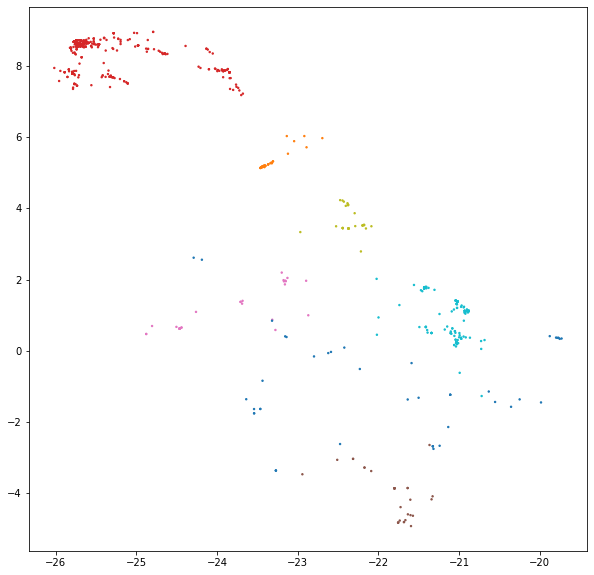

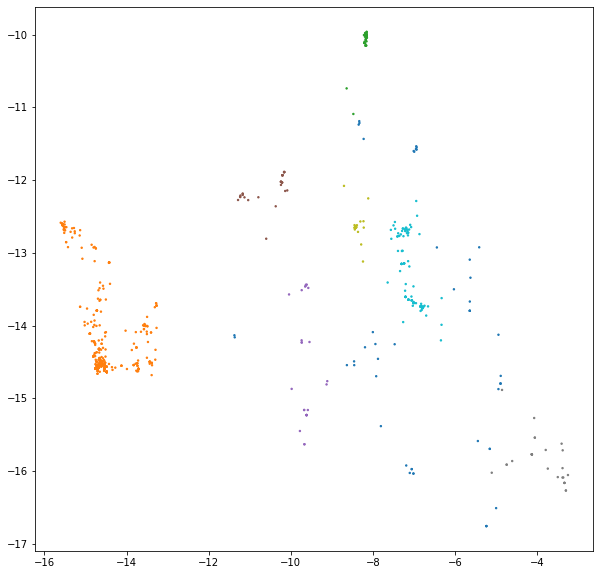

In [9]:
# Load the file containing the embedding runs and run the clustering each run
# save the cluster vectors to identify robustness of the clustering accross UMAP runs

with open(f'{outputDir}/umapRuns_mindist_001_neighbours_30_dims_2.pkl',"rb") as output:
    umapRuns=pkl.load(output)
#restore the runs from matrix of unique rows to matrix of full rows, but only keep CRhvKp isolates for clustering
onlyCRhvKpIDs=[f for f in metaData.index[metaData["isCRhvKp"]=="CRhvKp"] if f in PlasmidMatrixDFFull.index]

clusteringResults=pd.DataFrame(index=onlyCRhvKpIDs, columns=range(0,len(umapRuns)-2)) #-2 because "sampleIDs" and "dataToEmbed" are also part of the dictionary

for runNumber in range(0,len(umapRuns)-2): 
    runResult=np.zeros( (clusteringResults.shape[0],umapRuns[0].shape[1]), dtype=float)
    for k, sampleID in enumerate(clusteringResults.index):
        runResult[k,:]=umapRuns[runNumber][umapRuns["sampleIDs"][sampleID]]
    clusteringResults[runNumber]=hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.5).fit(runResult).labels_
    # Plot a few examples of clustering results, displaying all of them is not useful as there are too many.
    if runNumber<2:
        fig, axs = plt.subplots(1, 1)
        fig.set_size_inches(10,10)
        axs.scatter(runResult[:,0],runResult[:,1], c=clusteringResults[runNumber], s=2, cmap="tab10")
        plt.show()


/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


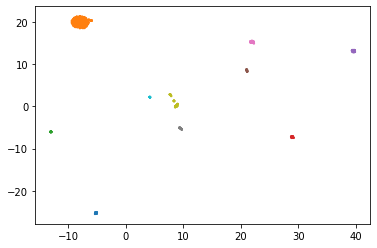

Cluster 8 has over 10% unassigned: 62%, changing label to unassigned
Counter({'A': 560, 'B': 83, 'C': 82, 'Unassigned': 79, 'D': 61, 'E': 50, 'F': 34, 'G': 32, 'H': 31, 'I': 16})


In [10]:
# Take a dataframe of all clusters vectors for individual UMAP runs and create embedding of them 
# use hamming metric because clusters numbering is categorical.
# The random_state is fixed so that embedding results can be replicated
umapRunsClustersEmbedding = umap.UMAP(n_neighbors=50, min_dist=0.01, n_components=2, metric="hamming", random_state=42).fit_transform(clusteringResults)    
umapRunsEmbeddingClusters=pd.DataFrame(data=hdbscan.HDBSCAN(min_cluster_size=15, cluster_selection_epsilon=0.5).fit(umapRunsClustersEmbedding).labels_,
                index=clusteringResults.index, columns=["Aggregated"] )
plt.scatter(umapRunsClustersEmbedding[:,0],umapRunsClustersEmbedding[:,1], s=2, c=umapRunsEmbeddingClusters["Aggregated"],
                cmap="tab20" if len(set(umapRunsEmbeddingClusters["Aggregated"]))>10 else "tab10" )
plt.show()

# HBSCAN does not force every sample to be part of some cluster. Such unassigned datapoints are given cluster -1
# Among the clusters identified based on all UMAP runs one likely represents consistently unassigned samples
# identify these and relabel the this cluster as Unassigned
for cluster in set(umapRunsEmbeddingClusters["Aggregated"]):
    totalUnassigned = np.count_nonzero( clusteringResults.loc[ umapRunsEmbeddingClusters["Aggregated"]==cluster  ] ==-1)
    totalDatapoints =  Counter( umapRunsEmbeddingClusters["Aggregated"])[cluster]  * clusteringResults.shape[1] 
    if totalUnassigned / totalDatapoints > 0.1:
        print(f'Cluster {cluster} has over 10% unassigned: {int(totalUnassigned / totalDatapoints * 100)}%, changing label to unassigned')
        umapRunsEmbeddingClusters.loc[ umapRunsEmbeddingClusters["Aggregated"]==cluster, "Aggregated" ] = -1


# Convert the numeric cluster labels to letters - these are easier on the ears and eyes
temp={k: v for k, v in sorted(Counter(umapRunsEmbeddingClusters["Aggregated"]).items(), key=lambda item: item[1], reverse=True)}
umapRunsEmbeddingClusters["Letter"]="Unassigned"
unassignedOffset=0
for i, cluster in enumerate(temp):
    if cluster==-1: #the cluster of unassigned values must be skipped for the letter IDs to be sequential
        unassignedOffset=-1
    else:
        umapRunsEmbeddingClusters.loc[ umapRunsEmbeddingClusters["Aggregated"]==cluster,"Letter" ]=list(string.ascii_uppercase)[i+unassignedOffset]

print(Counter(umapRunsEmbeddingClusters["Letter"]))

In [11]:
# HBSCAN does not force every sample to be part of some cluster. Such unassigned datapoints are given cluster -1
# Among the clusters identified based on all UMAP runs one likely represents consistently unassigned samples
# identify these and relabel the this cluster as Unassigned
for cluster in set(umapRunsEmbeddingClusters["Letter"]):
    totalUnassigned = np.count_nonzero( clusteringResults.loc[ umapRunsEmbeddingClusters["Letter"]==cluster  ] ==-1)
    totalDatapoints =  Counter( umapRunsEmbeddingClusters["Letter"])[cluster]  * clusteringResults.shape[1] 
    if totalUnassigned / totalDatapoints > 0.1:
        print(f'Cluster {cluster} has over 10% unassigned {int(totalUnassigned / totalDatapoints * 100)}%, changing label to unassigned')
        umapRunsEmbeddingClusters.loc[ umapRunsEmbeddingClusters["Letter"]==cluster, "Letter" ] = "Unassigned"

Cluster Unassigned has over 10% unassigned 62%, changing label to unassigned


In [12]:
# Create formatting for the figure displaying the CRKp, CRhvKp and hvKp isolates
# this allows colouring points by ST, Country and isCRhvKp as well as correct display of legend

choices={"BioSampleGeo":["China","USA","Italy","United Kingdom","Thailand","Germany","India"],"ST":["ST11","ST258","ST15","ST512","ST147","ST23","ST86","ST231"],
        "isCRhvKp":["CRhvKp","hvKp","CRKp","No"], "Clusters": sorted(list(set(umapRunsEmbeddingClusters["Letter"]))) }
for choice in choices:
    if choice!="isCRhvKp" and choice!="Clusters":
        choices[choice].append("Other")
colourDics={"BioSampleGeo":{},"ST":{},"isCRhvKp":{}, "Clusters": {}}
selectedCmaps={"BioSampleGeo":"Set1","ST":"tab10","isCRhvKp":"inferno", "Clusters":"tab20" if len(set(umapRunsEmbeddingClusters["Letter"]))>10 else "tab10" }
legendElementsDic={"BioSampleGeo":[],"ST":[],"isCRhvKp":[], "Clusters": []}
for key in colourDics:
    tempCmap=plt.cm.get_cmap(selectedCmaps[key], len(choices[key]))
    for value in choices[key]:
        if value!="Unassigned":
            colourDics[key][value]=tempCmap( len(colourDics[key]) / len(choices[key]) ) 
            legendElementsDic[key].append(mpatches.Patch(color=colourDics[key][value], label=value))
        else:
            colourDics[key][value]=(0, 0, 0, 1.0)
            legendElementsDic[key].append(mpatches.Patch(color=colourDics[key][value], label=value))
def getColour(sampleID,category):
    if metaData.at[sampleID,category] in colourDics[category]:
        return colourDics[category][metaData.at[sampleID,category]]
    else:
        return colourDics[category]["Other"]


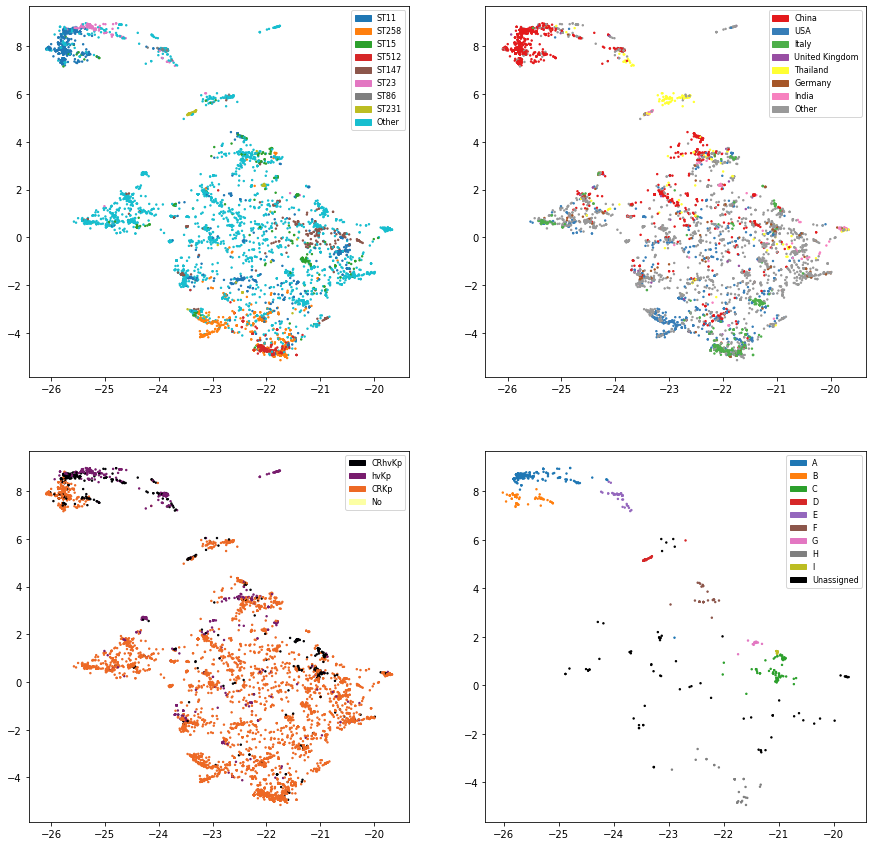

In [13]:
# This creates a scatter plot based on first run of UMAP embedding. 
# Because (all else equal), the first run uses specific seed, it's reproducable
# This simplifies figure formatting and reproduction

#restore the runs from matrix of unique rows to matrix of full rows, but only keep CRhvKp isolates for clustering
dataToEmbed=umapRuns["dataToEmbed"]

# Run 0 is special because it uses random_state. This means for that run result is the same if n_neighbors, min_dist and n_components are the same
runResult=np.zeros( (dataToEmbed.shape[0],umapRuns[0].shape[1]), dtype=float)
for k, sampleID in enumerate(dataToEmbed.index):
    runResult[k,:]=umapRuns[0][umapRuns["sampleIDs"][sampleID]]


fig, axs = plt.subplots(2,2)
fig.set_size_inches(15,15)
for i, category in enumerate(["ST", "BioSampleGeo", "isCRhvKp"]):
    axs[int(i/2), i % 2].scatter(runResult[:,0], runResult[:,1], s=2, c=[ getColour(f,category)  for f in dataToEmbed.index])
    axs[int(i/2), i % 2].legend(handles=legendElementsDic[category],prop={'size': 8}, loc="best")

onlyCRhvKpIDsIndices=[i for i, index in enumerate(dataToEmbed.index) if index in onlyCRhvKpIDs]
axs[1,1].scatter(runResult[onlyCRhvKpIDsIndices,0], runResult[onlyCRhvKpIDsIndices,1], s=2, c=[colourDics["Clusters"][ umapRunsEmbeddingClusters.at[f,"Letter"]] for f in dataToEmbed.index[onlyCRhvKpIDsIndices] ])
axs[1, 1].legend(handles=legendElementsDic["Clusters"],prop={'size': 8}, loc="best")
plt.show()

# Output the run[0] together with clusters to a file
with open(f'{outputDir}embedding.tsv',"w") as output:
    output.write("Assembly\tCluster\tX1\tX2\tST\tCountry\tCollectionYear\tAerobactin\tSalmochelin\tSpecies\tBla_Carb_acquired\tGenotype\n")
    for i, index in enumerate(dataToEmbed.index):
        output.write("\t".join( str(f) for f in [ index, umapRunsEmbeddingClusters.at[index,"Letter"] if index in umapRunsEmbeddingClusters.index else "",
                     runResult[i,0], runResult[i,1], metaData.at[index,"ST"],
                     metaData.at[index,"BioSampleGeo"], metaData.at[index,"CollectionDate"], metaData.at[index, "Aerobactin"], 
                     metaData.at[index, "Salmochelin"], metaData.at[index, "species"], metaData.at[index, "Bla_Carb_acquired"],
                     metaData.at[index, "isCRhvKp"] ] )+"\n")

E
G
F
I
H
A
C
D
Unassigned
B


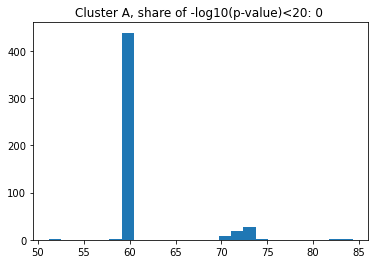

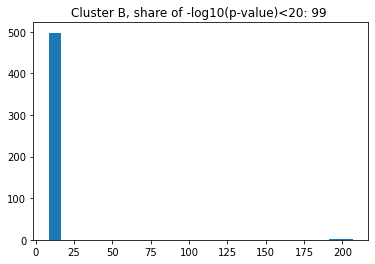

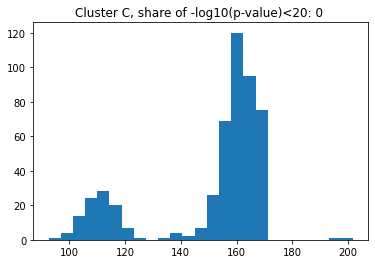

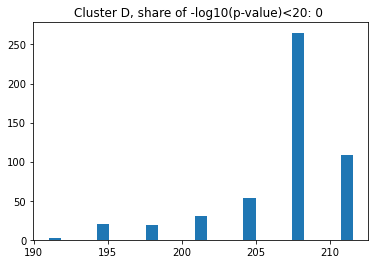

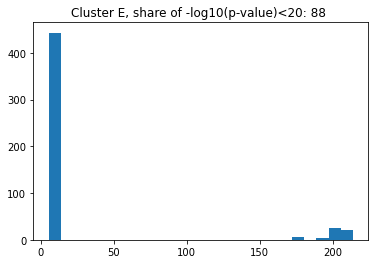

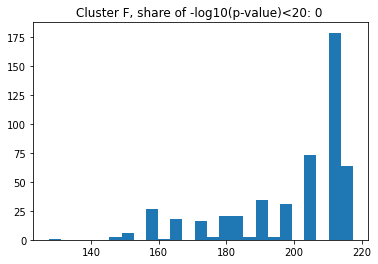

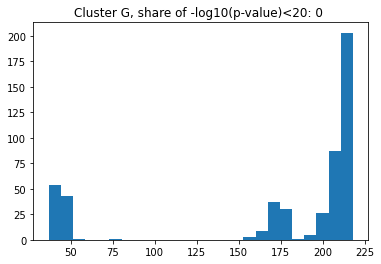

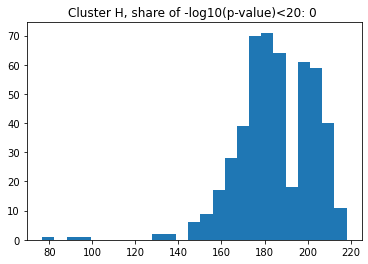

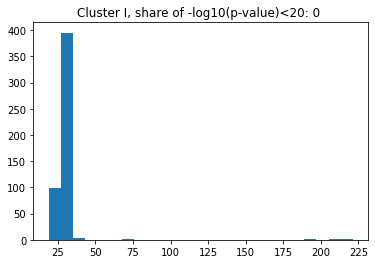

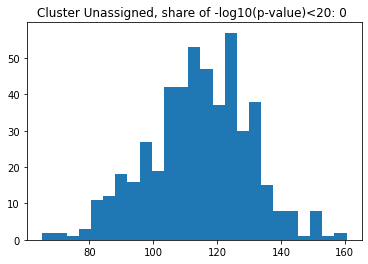

In [14]:
# The dimensional reduction and clustering of all cluster vectors from individual UMAP runs produced a vector of clusters
# The robustness of this clustering vector can be assesed using chi2 test
# However, the cluster numbering for different UMAP runs will be different. 
# i.e. even if same N points form a cluster, the number for that cluster in one UMAP run may be different from another
# So I need to iterate chi2 test over all the clusters and identify the one with lowest -log10(pvalue)

chi2tests=pd.DataFrame(index=range(0,len(umapRuns)-1), columns=set(umapRunsEmbeddingClusters["Letter"]))
for cluster in chi2tests.columns:
    print(cluster)
    x=np.zeros( (len(umapRunsEmbeddingClusters["Letter"]) ), dtype=int )
    x[np.where(umapRunsEmbeddingClusters["Letter"]==cluster)[0]]=1
    for runNumber in clusteringResults:
        #in a given run the cluster # can be anything and generally has no relationship to cluster number of run aggregates
        #thus I need to test all clusters in given run and take one with lowest p-value
        lowestpvalue=1
        for runcluster in set(clusteringResults[runNumber]):
            y=np.zeros( (len(umapRunsEmbeddingClusters["Letter"]) ), dtype=int )
            y[np.where(clusteringResults[runNumber]==runcluster)[0]]=1
            chi2value, pvalue=chi2(x.reshape(-1, 1),y.reshape(-1, 1))
            if pvalue[0]<lowestpvalue:
                lowestpvalue=pvalue[0]
        chi2tests.at[runNumber, cluster]=-np.log10(lowestpvalue)

# Plot the results for each cluster as historgram 
for cluster in sorted(chi2tests.columns):
    plt.hist(chi2tests[cluster], bins=25)
    plt.title(f'Cluster {str(cluster)}, share of -log10(p-value)<20: { int(np.count_nonzero(chi2tests[cluster]<20)/chi2tests.shape[0]*100) } ' )
    plt.show()


In [15]:
# Create table with replicon frequences per cluster, per collection year and per genotype

isolatesSubset=[f for f in metaData.index[ (metaData["isCRhvKp"]=="CRKp") | (metaData["isCRhvKp"]=="CRhvKp") | (metaData["isCRhvKp"]=="hvKp") ] if f in PlasmidMatrixDFFull.index]

repliconFrequencies=pd.DataFrame(index=PlasmidMatrixDFFull.columns, columns=['CRKp', 'CRhvKp', 'No', 'hvKp'])
repliconFrequencies.index.name = "PlasmidSequenceHash"
repliconFrequencies["Name"]=[hashFamilies[f] for f in repliconFrequencies.index]
#for repliconhash in PlasmidMatrixDFFull.columns:
for genotype in ['CRKp', 'CRhvKp', 'No', 'hvKp']:
    isolatesSubset=[f for f in metaData.index[ (metaData["isCRhvKp"]==genotype)  ] if f in PlasmidMatrixDFFull.index]
    repliconFrequencies[genotype]=np.count_nonzero(PlasmidMatrixDFFull.loc[ isolatesSubset ][repliconFrequencies.index],axis=0)
repliconFrequencies["Total"]=np.sum(repliconFrequencies[['CRKp', 'CRhvKp', 'No', 'hvKp']],axis=1)

for year in ["2010","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020"]:
    isolatesSubset=[f for f in metaData.index[ (metaData["CollectionDate"]==year)  ] if f in PlasmidMatrixDFFull.index]
    repliconFrequencies[year]=np.count_nonzero(PlasmidMatrixDFFull.loc[ isolatesSubset ][repliconFrequencies.index],axis=0)

dataToEmbed=umapRuns["dataToEmbed"]
for cluster in sorted(list(set(umapRunsEmbeddingClusters["Letter"]))):
    isolatesSubset=umapRunsEmbeddingClusters["Letter"].index[umapRunsEmbeddingClusters["Letter"]==cluster]
    repliconFrequencies[cluster]=np.count_nonzero(PlasmidMatrixDFFull.loc[ isolatesSubset ][repliconFrequencies.index],axis=0)
repliconFrequencies["Sequence"]=[hashSequences[f] if f in hashSequences else "" for f in repliconFrequencies.index]


print(len(np.unique(repliconFrequencies.index[repliconFrequencies["Sequence"]==""])))
repliconFrequencies.to_csv(f'{outputDir}/repliconFrequencies.tsv', sep="\t")
repliconFrequencies.loc[repliconFrequencies["Name"]=="IncFIB(K)"].to_csv(f'{outputDir}/repliconFrequencies_IncFIB(K).tsv', sep="\t")

181


In [39]:
# Check which replicon sequences has statistical association with which carbapenemases
uniqueCarbapenemases=set()
for key, value in Counter(metaData["Bla_Carb_acquired"]).items():
    items=key.split(";")
    for item in items:
        itemCount=sum([ 1 for f in metaData.index if metaData.at[f,"Bla_Carb_acquired"].find(item)>-1  ])
        # Only use carbapenemase which occur more than 20 times, otherwise chi2 test is unlikely to be appropriate
        if itemCount>30:
            uniqueCarbapenemases.add(item)

carbapenemaseDF=pd.DataFrame(index=PlasmidMatrixDFFull.index, columns=uniqueCarbapenemases)
for carbapenemase in carbapenemaseDF.columns:
    carbapenemaseDF[carbapenemase]=[ 1 if metaData.loc[f,"Bla_Carb_acquired"].find(carbapenemase)>-1 else 0 for f in PlasmidMatrixDFFull.index  ]

In [65]:
# Chi2 test for association between replicon hash and carbapenemase

hashesVsCarbapenemases=pd.DataFrame(index=PlasmidMatrixDFFull.columns[ PlasmidMatrixDFFull.sum(axis=0)>30  ] , columns=uniqueCarbapenemases)
for hash in hashesVsCarbapenemases.index:
    for carbapenemase in hashesVsCarbapenemases.columns:
        x=np.asarray(PlasmidMatrixDFFull[hash])
        y=np.asarray(carbapenemaseDF[carbapenemase])
        chi2value, pvalue=chi2(x.reshape(-1,1),y.reshape(-1,1))
        hashesVsCarbapenemases.at[hash,carbapenemase]=-np.log10(pvalue[0])

hashesVsCarbapenemases["Family"]=[hashFamilies[f] for f in hashesVsCarbapenemases.index]
hashesVsCarbapenemases["IsolatesWithHash"]=[sum(PlasmidMatrixDFFull[f]) for f in hashesVsCarbapenemases.index]
hashesVsCarbapenemases.to_csv(f'{outputDir}/hashCarbapenemaseChi2.tsv', sep="\t")

/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide

In [63]:
from sklearn import metrics
hash="ed04776b67de8f9895cb0e2c207900ad"
carbapenemase="NDM-1"
confusion_matrix=metrics.confusion_matrix(PlasmidMatrixDFFull[hash],carbapenemaseDF[carbapenemase])
confusion_matrix

array([[11570,   824],
       [   73,     1]])

In [ ]:
# This calculates the chi2 test for IncHI1B(pNDM-MAR) plasmid replicon and country, ST, and clusters

hashesOfIncHI1Breplicon=[f for f in PlasmidMatrixDFFull.columns if hashFamilies[f]=="IncHI1B(pNDM-MAR)"]
samplesWithIncHI1Breplicon=PlasmidMatrixDFFull.index[ PlasmidMatrixDFFull[hashesOfIncHI1Breplicon].sum(axis=1)>0  ]
testDataMatrix=pd.DataFrame(index=samplesWithIncHI1Breplicon, columns=["ST","Country","Year","Cluster","IncHI1Bhash"])
testDataMatrix["ST"]=metaData.loc[testDataMatrix.index, "ST"]
testDataMatrix["Country"]=metaData.loc[testDataMatrix.index, "BioSampleGeo"]
testDataMatrix["Year"]=metaData.loc[testDataMatrix.index, "CollectionDate"]
testDataMatrix["Cluster"]=[umapRunsEmbeddingClusters.at[f,"Letter"] if f in umapRunsEmbeddingClusters.index else "Other" for f in testDataMatrix.index]
# To make the assignment of hashes easier to read it's done as a loop
for sample in testDataMatrix.index:
    allPresentHashes=np.asarray(hashesOfIncHI1Breplicon)[PlasmidMatrixDFFull.loc[sample, hashesOfIncHI1Breplicon]>0]
    randomPresentHash=random.sample(list(allPresentHashes),1)[0]
    testDataMatrix.at[sample,"IncHI1Bhash"]=randomPresentHash

# Drop hashes occuring fewer than 5 times
validHashes=[key for key, value in Counter(testDataMatrix["IncHI1Bhash"]).items() if value>5]

testDataMatrix=testDataMatrix.loc[ [f for f in testDataMatrix.index if testDataMatrix.at[f,"IncHI1Bhash"] in validHashes ] ]

x=testDataMatrix["IncHI1Bhash"]
for feature in ["ST","Country","Year","Cluster"]:
    y=testDataMatrix[feature]
    chi2value, pvalue=chi2(x,y)
    print(-np.log10(pvalue))

In [83]:
x=testDataMatrix["IncHI1Bhash"].astype('category').cat.codes
for feature in ["ST","Country","Year","Cluster"]:
    y=testDataMatrix[feature].astype('category').cat.codes
    chi2value, pvalue=chi2(np.asarray(x).reshape(-1, 1),np.asarray(y).reshape(-1, 1))
    print(-np.log10(pvalue))

[37.62223751]
[13.45230845]
[2.65079118]
[45.38678296]
